### Load Dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2024-05-25 18:25:37--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  29.0MB/s    in 9.4s    

2024-05-25 18:25:47 (26.7 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [ ]:
!unzip -qq ml-25m.zip

In [ ]:
file_ratings = '/content/ml-25m/ratings.csv'
file_movies = '/content/ml-25m/movies.csv'

In [ ]:
import numpy as np
import csv

def create_movie_names(file_path):
    global movie_id_map
    movie_names = np.empty(N, dtype=object)

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            movie_id = np.int64(row['movieId'])
            movie_name = row['title']

            if movie_id not in movie_id_map:
                continue

            movie_index = movie_id_map[movie_id]
            movie_names[movie_index] = movie_name

    return movie_names


def create_rating_matrix(file_path):
    global user_id_map, movie_id_map
    ratings = []

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            user_id = np.int64(row['userId'])
            movie_id = np.int64(row['movieId'])
            rating = np.int64(float(row['rating']) * 2)

            if user_id not in user_id_map:
                user_id_map[user_id] = len(user_id_map)

            if movie_id not in movie_id_map:
                movie_id_map[movie_id] = len(movie_id_map)

            user_index = user_id_map[user_id]
            movie_index = movie_id_map[movie_id]

            ratings.append([user_index, movie_index, rating])

    return np.array(ratings)


def index(ratings, index_type="user"):
    locations = []
    i = 0

    if index_type == "user":
        current_id = ratings[0][0]
    else:
        current_id = ratings[0][1]

    locations.append(i)
    for user_id, movie_id, _ in ratings:
        if index_type == "user":
            if current_id != user_id:
                locations.append(i)
                current_id = user_id
            i += 1
        else:
            if current_id != movie_id:
                locations.append(i)
                current_id = movie_id
            i += 1

    return np.array(locations)

In [ ]:
user_id_map = {}
movie_id_map = {}
ratings = create_rating_matrix(file_ratings)
N = len(movie_id_map)
M = len(user_id_map)

In [ ]:
movie_names = create_movie_names(file_movies)

In [ ]:
sorted_by_user = ratings[ratings[:, 0].argsort()]
sorted_by_movie = ratings[ratings[:, 1].argsort()]

In [ ]:
user_index = index(sorted_by_user, "user")
movie_index = index(sorted_by_movie , "movie")

In [ ]:
total_ratings = len(ratings)

### Plot Ratings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(ratings):
    blue_color = '#1f77b4'
    ratings = ratings[:, 2]
    plt.figure(figsize=(10, 6))

    bins = np.arange(0.5, 11.5, 1)
    plt.hist(ratings, bins=bins, color=blue_color, edgecolor='black')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

    plt.xticks(np.arange(1, 11, 1), labels=np.arange(0.5, 5.5, 0.5))
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.savefig('Rating_distribution.pdf')
    plt.show()

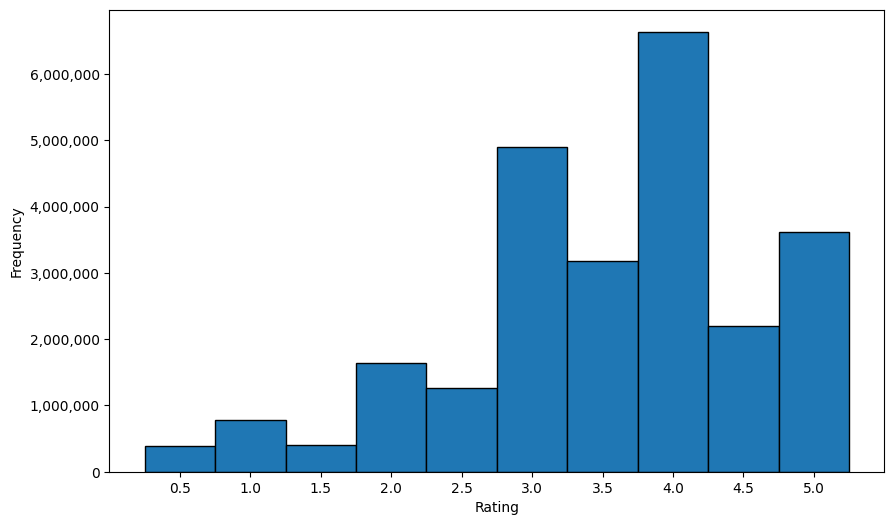

In [ ]:
plot_distribution(ratings)

### Plot Power

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_power(user_index, movie_index, total_ratings):
    blue_color = '#1f77b4'
    rating_distribution_user = np.zeros(M)

    for m in range(M):
        start_index = user_index[m]
        end_index = user_index[m + 1] if m + 1 < M else total_ratings
        rating_distribution_user[m] = end_index - start_index

    rating_distribution_movie = np.zeros(N)

    for m in range(N):
        start_index = movie_index[m]
        end_index = movie_index[m + 1] if m + 1 < N else total_ratings
        rating_distribution_movie[m] = end_index - start_index

    user_degrees, user_counts = np.unique(rating_distribution_user, return_counts=True)
    movie_degrees, movie_counts = np.unique(rating_distribution_movie, return_counts=True)

    plt.figure(figsize=(10, 8))
    plt.loglog(user_degrees, user_counts, '.', color=blue_color, label='Users')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('User_degree.pdf')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.loglog(movie_degrees, movie_counts, 'g.', label='Movies')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('Movie_degree.pdf')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.loglog(user_degrees, user_counts, '.', color=blue_color, label='Users')
    plt.loglog(movie_degrees, movie_counts, 'g.', label='Movies')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('User_Movie_degree.pdf')
    plt.show()

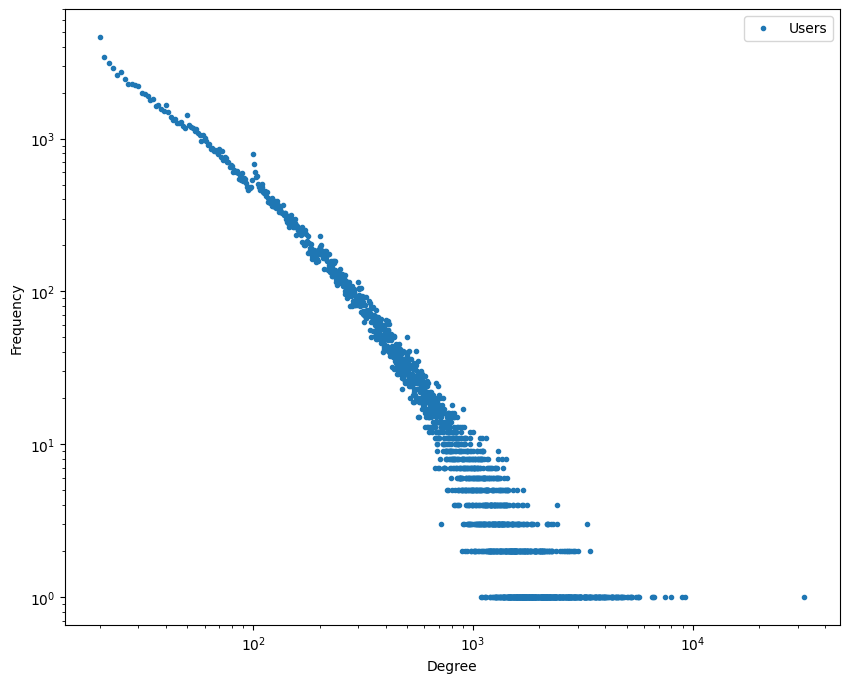

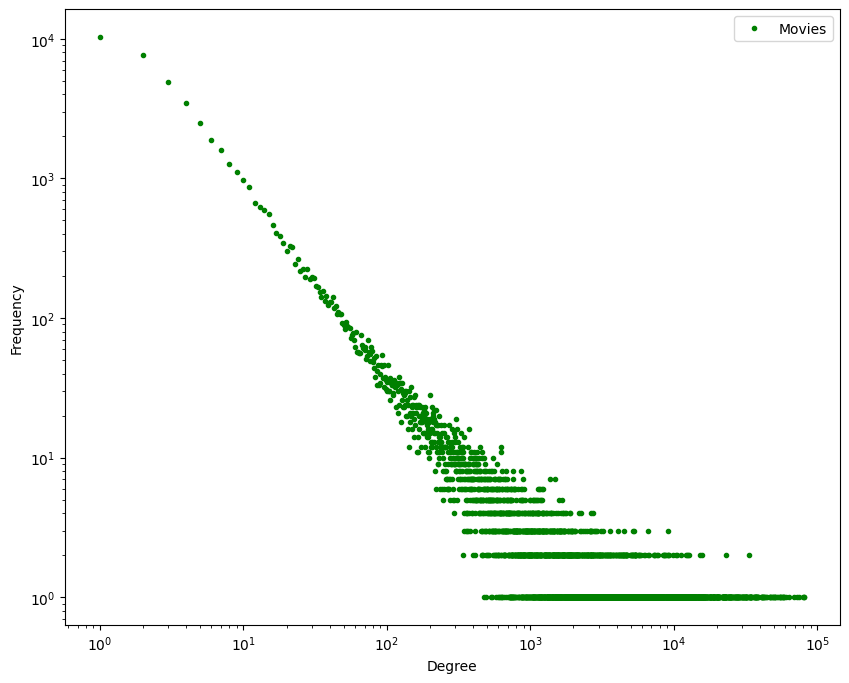

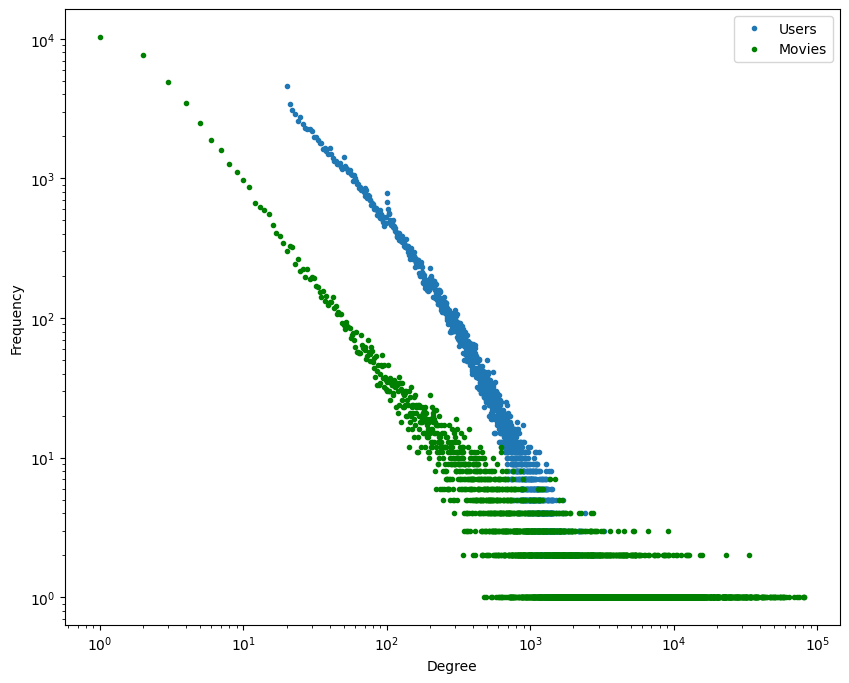

In [ ]:
plot_power(user_index, movie_index, total_ratings)

### Plot Genres

In [ ]:
import csv
from collections import defaultdict

def count_genres(file_path):
    genre_counts = defaultdict(int)

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)

        for row in reader:
            genres = row['genres'].split('|')

            for genre in genres:
                genre_counts[genre] += 1

    return genre_counts

In [ ]:
import matplotlib.pyplot as plt

def plot_genre_counts(genre_counts):
    genres = [
        "Action", "Adventure", "Animation", "Children's", "Comedy",
        "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
        "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
        "Thriller", "War", "Western", "(no genres listed)"
    ]

    counts = [genre_counts[genre] for genre in genres]
    blue_color = '#1f77b4'

    plt.figure(figsize=(12, 8))
    plt.bar(genres, counts, color=blue_color)
    plt.xlabel('Genres')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('Genre_distribution.pdf')
    plt.show()

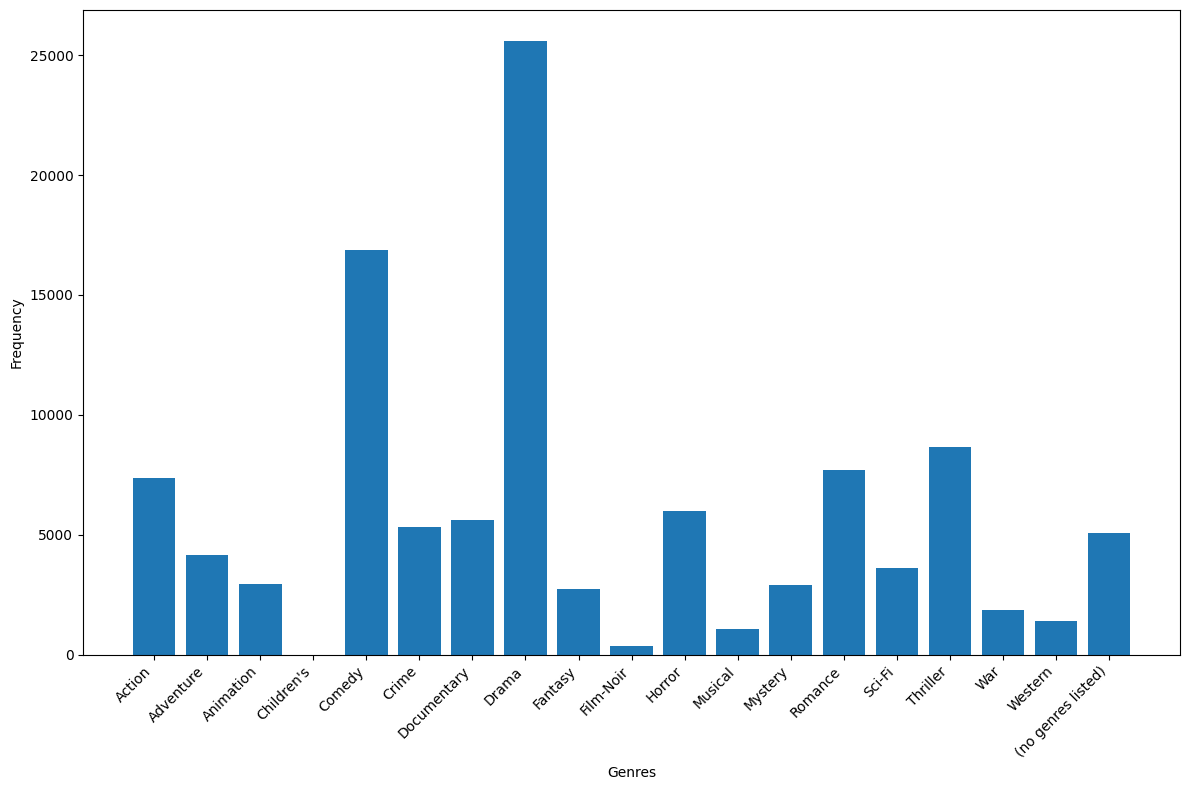

In [ ]:
genre_counts = count_genres(file_movies)
plot_genre_counts(genre_counts)